### Project 3: Plausible Utopia 

### Classification Modeling on Subreddits to Classify Futurists vs. Scientists

### Notebook 1 of 3: Preprocessing, EDA 

### Problem statement

Enthralled as I am with the future, high-flying visions of art merging with technology that bring about utopia seem  ungrounded and unscientific.

Using classification models on datasets collected from the [`futurology`](https://www.reddit.com/r/Futurology) and [`science`](https://www.reddit.com/r/Science) subreddits, I'd like to answer some of the below questions (where possible):

* Are the futurist and scientist communities mutually exclusive? 

* What is the nature of the discussions amongst the scientist community?

* What is the nature of the discussions amongst the futurist community?

* Where is there topical crossover between these discussions, if any? 

* Does the topical crossover support any of the visions of the future held and propagated by futurists, such as:
  
     * Mind uploading, digital heaven, etc.
     * Reverse-aging, insect-based diets, colonization of other planets, etc.

* Furthermore, are solutions being discussed to the disaster-visions of futurists, such as:
    * Food and water shortages
    * Environmental disasters



#### Libary imports

In [1103]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
     
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from sklearn.feature_extraction.text import CountVectorizer
import string


import warnings; warnings.simplefilter('ignore')
##this will hide deprecation/future warnings

from IPython.display import Markdown, display
pd.set_option('display.max_row', 200) # Set ipython's max row display
pd.set_option('display.max_columns', 85) # Set iPython's max column count
pd.set_option('display.max_colwidth', 1_000) # Set iPython's max column width

# pseudo-markdown in code cells
def printmd(string):
    display(Markdown(string))
# ref: https://discuss.analyticsvidhya.com/t/how-to-make-a-text-bold-within-print-statement-in-ipython-notebook/14552/2

#### Data collection

I utilized the Python Reddit API Wrapper (PRAW) API in the data collection process. You can find the steps I took in the `PRAW_data_collection` notebook, located in the code folder of this repository.

The East Coast local instructors were very generous with their walkthrough of the process, so I definitely credit them for the ease of the data collection.

From the [rubric](https://git.generalassemb.ly/abishop17/project_3/blob/master/README.md):

>Was data collection and storage optimized through custom functions, pipelines, and/or automation? <br><br>
>Was thought given to the server receiving the requests such as considering number of requests per second?

#### Preprocessing and EDA

#### Dataset 1: "New" flavor, pulled from Reddit on 10/13/20

In [1104]:
subred = pd.read_csv('../data/df_with_both_subs.csv')
subred = subred.drop(columns = 'Unnamed: 0')
display(pd.set_option('display.max_colwidth', 50), subred.head())

None

,title,score,id,url,comms_num,created,body,subreddit
0,What would the point be to do anything if AI c...,0,japxs3,https://www.reddit.com/r/Futurology/comments/j...,4,1.602664e+09,The more I look into AI and new projects like ...,futurology
1,ELCC Explained: the Critical Renewable Energy ...,4,japq75,https://blog.ucsusa.org/mark-specht/elcc-expla...,0,1.602663e+09,NaN,futurology
2,There's a 50-50 chance we're living in a simul...,8,jaojnb,https://boingboing.net/2020/10/13/new-research...,4,1.602659e+09,NaN,futurology
3,"Eight nations sign NASA's Artemis Accords, ple...",3,jaofpy,https://www.engadget.com/nasa-artemis-accords-...,1,1.602658e+09,NaN,futurology
4,Mercedes benz AVTR - In Action,8,jaocqq,https://www.youtube.com/watch?v=ChqM3zqTREQ&ab...,0,1.602658e+09,NaN,futurology


---

### EDA

In [1105]:
display(subred[['title', 'subreddit']].head(1))
display(subred[['title', 'subreddit']].tail(1))

,title,subreddit
0,What would the point be to do anything if AI c...,futurology


,title,subreddit
1799,Study finds middle-aged individuals — those bo...,science


#### Address duplicates

In [1106]:
printmd('**Count of unique titles:**')
display(subred['title'].nunique())
printmd('**Count of titles before dropping duplicates:**')
display(subred['title'].count())

subred = subred.drop_duplicates()

printmd('**Count of titles after dropping duplicates:**')
subred['title'].nunique()

**Count of unique titles:**

1778

**Count of titles before dropping duplicates:**

1800

**Count of titles after dropping duplicates:**

1778

In [1107]:
printmd('**Value counts:**')
display(subred['subreddit'].value_counts())

printmd('**Value counts by weight:**')
subred['subreddit'].value_counts(normalize = True)

**Value counts:**

science       931
futurology    869
Name: subreddit, dtype: int64

**Value counts by weight:**

science       0.517222
futurology    0.482778
Name: subreddit, dtype: float64

* I may want to return to the subreddits to get a bigger dataset to work with. 

* The classes are slightly unbalanced, so that will be a consideration during the preprocessing / get-more-data phase.

In [1108]:
# Null body rows
printmd(f"**Only {len(subred['body'][(subred['body'].isnull()).astype(int) == 0])} non-null `body` records.**")

non_null_body = subred[['body', 'subreddit']][(subred['body'].isnull()).astype(int) == 0]

**Only 69 non-null `body` records.**

**Ignore `body` column since there are so few in the dataset.**

In [1109]:
printmd('**Can we get enough content from post titles?**')

**Can we get enough content from post titles?**

---

In [1110]:
display(pd.set_option('display.max_colwidth', 300), subred[['title', 'body']])

None

,title,body
0,What would the point be to do anything if AI could just do it all for us?,"The more I look into AI and new projects like GPT-3, we humans suck. Sure GPT-3 isn't on the level as a human brain, but that doesn't mean gpt-4 or gpt-5 won't be. I can already see the massive jobs loss as AI will offset more jobs than it will create. I'm just feeling a little existential cris..."
1,"ELCC Explained: the Critical Renewable Energy Concept You’ve Never Heard Of ""Now we live in a day and age where some parts of the country generate more than 30% of their electricity with variable renewables, and that number will fast approach 100% in the decades to come.""",NaN
2,"There's a 50-50 chance we're living in a simulation and here's how to find out ""the probability will increase as we develop technology enabling the creation of a simulation containing conscious beings.""",NaN
3,"Eight nations sign NASA's Artemis Accords, pledging peace on the moon ""It's a reaffirmation of the 1967 Outer Space Treaty.""",NaN
4,Mercedes benz AVTR - In Action,NaN
...,...,...
1795,Adults with positive SARS-CoV-2 test results were approximately twice as likely to have reported dining at a restaurant than were those with negative SARS-CoV-2 test results.,NaN
1796,50% of Phosphorus Lost to Erosion,NaN
1797,Motivated Helplessness in the Context of the Covid-19 Pandemic: Evidence for a Curvilinear Relationship Between Perceived Ability to Avoid the Virus and Anxiety,NaN
1798,"Political ideology may explain why despair spreads faster than hope during times of conflict, study suggests",NaN


**Lemmatizing**, ***aka Soft wash***

In [1111]:
lemmatizer = WordNetLemmatizer()

def split_and_lemmatize(string):
    word = ''
    for i in string.split():
        word += lemmatizer.lemmatize(i + ' ')
    return word

# Lemmatize titles

display(subred['title'].apply(split_and_lemmatize).head(1))

0    What would the point be to do anything if AI could just do it all for us? 
Name: title, dtype: object

**Stemming**, ***aka Aggressive wash***

In [1112]:
# stemmer = PorterStemmer()  #instantiate stemmer

# def split_and_stem(string):
#     word = ""   #empty string
#     string = string.split(' ') #creates list of words
#     for i in string: #iterates through that list of words
#         word += (stemmer.stem(i) + " ")  #stems each word and adds to empty string
#     return word  #returns string with stemmed words

# # ref: Heather Robinson at General Assembly :-)

# Apply stemming to title 

# subred1['title'] = subred1['title'].apply(split_and_stem)

# subred1['title'].head()

#### Binarize the target feature: `1` for Science, `0` for Futurology

In [1113]:
# Check the balance of classes

printmd('**Balance of classes before binarizing**')
display(subred['subreddit'].value_counts())
display(subred['subreddit'].value_counts(normalize = True))

# subred['subreddit'] = subred['subreddit'].map({'science': 1, 'futurology': 0})

# printmd('**Balance of classes after binarizing (Science: 1, Futurology: 0)**')
# display(subred['subreddit'].value_counts())

**Balance of classes before binarizing**

science       931
futurology    869
Name: subreddit, dtype: int64

science       0.517222
futurology    0.482778
Name: subreddit, dtype: float64

In [1123]:
subred.to_csv('../data/cleaned_data/cleaned_df.csv')

### Cutoff point 

#### To toggle between Option 1 (EDA)  and Option 2 (Optimal modeling) below:
**Step 1**: Click on this cell, then select the following from the Jupyter Notebook menu:  `Cell`  > `Run all above`

**Step 2**: Run the cells within each section below

**Step 3**: After running the last cell within the section, repeat `Step 1`, and go to the next section 

---

#### Set the features

In [1114]:
# Set feature matrix and target variable

X = subred['title']
y = subred['subreddit']

### Implement CountVectorizer for purposes of EDA

### Preprocessing
- Remove special characters
- Tokenize
- Lemmatize / stem
- Remove stop words

#### CountVectorizer

1. Count number of times a token is observed in a given subreddit post

2. Create a vector to store those counts

In [1115]:
subred = subred[['title', 'subreddit']]

#### Document Term Matrix

In [1116]:
subred['title'] = subred['title'].apply(split_and_lemmatize)

subred_grouped_by_sub = subred[['subreddit', 'title']].groupby(by = 'subreddit').agg(lambda x: ' '.join(x))

# Create a Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer = 'word', stop_words = 'english')

subred_grouped_by_sub_new = cv.fit_transform(subred_grouped_by_sub['title'])

df_doc_term_matrix = pd.DataFrame(subred_grouped_by_sub_new.todense(), columns = cv.get_feature_names())

df_doc_term_matrix['subreddit'] = subred_grouped_by_sub.index
subreddit_col = df_doc_term_matrix.pop('subreddit')
df_doc_term_matrix.insert(0, 'subreddit', subreddit_col)

df_doc_term_matrix

# ref: https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

,subreddit,000,01,012,026,061,083,10,100,1000,1000x,100m,1010g,1062,107,10g,10gw,10th,11,113,114,116,117,12,120,121b,124,125,1273,12m,13,130,13m,14,149m,14th,15,150,1500,1500s,1552,156,...,wrongdoers,wrote,wsj,xanadu,xi,xnh,xpeng,yards,year,years,yes,yield,yields,yo,yoga,york,yorkers,young,younger,youth,youtube,youtubers,yr,ytd,yunan,zappar,zebrafish,zeolitic,zero,zeroavia,zinc,zip,zipline,zips,zircon,zn,zombie,zone,zoologists,zoom,αc,μg
0,futurology,25,0,0,0,0,0,19,12,2,1,1,0,0,0,3,1,1,2,1,1,0,1,9,0,0,0,1,0,0,2,0,1,5,1,1,3,2,0,0,0,0,...,0,1,1,1,1,0,2,0,20,32,1,0,1,1,0,1,0,3,0,0,0,1,2,1,0,1,1,1,11,3,1,0,1,0,1,1,4,1,0,2,0,0
1,science,19,1,1,1,1,1,17,9,0,0,0,1,1,1,0,0,0,8,2,0,1,0,8,2,1,1,0,2,1,8,1,0,3,0,1,11,2,1,1,1,1,...,1,0,0,0,0,1,0,1,18,33,0,3,0,0,1,2,1,10,3,2,1,0,1,0,1,0,1,1,2,0,0,1,0,1,0,0,0,0,1,0,1,2


#### Most common words

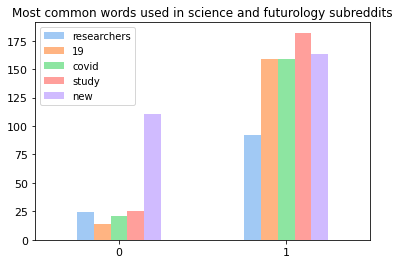

In [1117]:
# Most common words used in science and futurology subreddits

top_words = df_doc_term_matrix.iloc[:, 1:].sum().sort_values(ascending = False)[:5][::-1]
top_words = df_doc_term_matrix[[word for word in pd.Series(top_words).index]]

top_words.plot.bar()

plt.title('Most common words used in science and futurology subreddits')
plt.xticks(size = 11, rotation = 0)
plt.yticks(size = 11);

In [1101]:
# Most common words used in science subreddit

top_words_science_only = df_doc_term_matrix[df_doc_term_matrix['subreddit'] == 'science'].sum().sort_values(ascending = False)[:5][::-1]
top_words_science_only = df_doc_term_matrix[[word for word in pd.Series(top_words_science_only).index]]

top_words_science_only.plot.bar()

plt.title('Most common words used in science subreddit')
plt.xticks(size = 11, rotation = 0)
plt.yticks(size = 11);

TypeError: '<' not supported between instances of 'numpy.ndarray' and 'str'

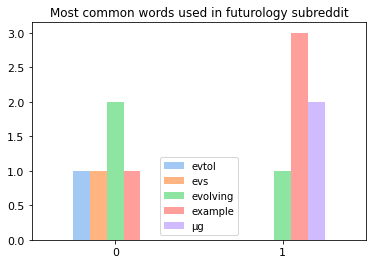

In [1096]:
# Most common words used in futurology subreddit

top_words_futurology_only = df_doc_term_matrix[df_doc_term_matrix.index == 'futurology'].sum().sort_values(ascending = False)[:5][::-1]
top_words_futurology_only = df_doc_term_matrix[[word for word in pd.Series(top_words_futurology_only).index]]

top_words_futurology_only.plot.bar()

plt.title('Most common words used in futurology subreddit')
plt.xticks(size = 11, rotation = 0)
plt.yticks(size = 11);

#### Distribution of vocabulary (total word count per class)

In [1120]:
df_doc_term_matrix['subreddit'] = df_doc_term_matrix['subreddit'].map({'science': 1, 'futurology': 0})

df_doc_term_matrix.sum().sort_values(ascending = False)[:200]

new             274.0
study           207.0
covid           180.0
19              173.0
researchers     116.0
people          114.0
energy          106.0
climate         106.0
world            97.0
scientists       97.0
future           91.0
time             83.0
change           81.0
solar            79.0
ai               75.0
hydrogen         72.0
brain            67.0
human            66.0
years            65.0
use              64.0
help             58.0
like             58.0
sars             58.0
research         57.0
power            57.0
cov              56.0
cells            55.0
finds            54.0
pandemic         53.0
carbon           52.0
global           51.0
shows            50.0
health           50.0
likely           49.0
using            48.0
life             48.0
million          47.0
fuel             46.0
used             45.0
children         44.0
000              44.0
high             44.0
quantum          43.0
emissions        42.0
make             42.0
based     

In [1121]:
# Instantiate CountVectorizer 
cvec = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on the corpus
X = cvec.fit_transform(X)

printmd('**Size of feature matrix:**')
display(X.shape)

printmd(f'**Count of tokens:** {len(cvec.get_feature_names())}')

printmd('**Have a look at random slices of our tokens:**')
for i in np.arange(0, len(cvec.get_feature_names()), step = 1_000):
    increment = 20
    print('\n', cvec.get_feature_names()[i: i + increment])

**Size of feature matrix:**

(1800, 7577)

**Count of tokens:** 7577

**Have a look at random slices of our tokens:**


 ['000', '01', '012', '026', '061', '083', '10', '100', '1000', '1000x', '100m', '1010g', '1062', '107', '10g', '10gw', '10th', '11', '113', '114']

 ['boost', 'boosted', 'boosting', 'boosts', 'boot', 'boots', 'borderline', 'bored', 'boris', 'born', 'boson', 'boss', 'bot', 'bots', 'bottle', 'bottles', 'boudinot', 'boundaries', 'bowel', 'box']

 ['developers', 'developing', 'development', 'developmental', 'develops', 'device', 'devices', 'devils', 'devise', 'dewi', 'diabetes', 'diabetics', 'diagnose', 'diagnosed', 'diagnoses', 'diagnosis', 'diagnostic', 'diamond', 'diamonds', 'dictators']

 ['geo', 'geobiologists', 'geoengineering', 'geographically', 'geologic', 'geological', 'geopolitics', 'geoscientist', 'geothermal', 'german', 'germans', 'germany', 'germinal', 'gesture', 'gets', 'getting', 'ghez', 'gi', 'giant', 'gibbons']

 ['linked', 'links', 'linoleic', 'lions', 'lip', 'lipase', 'lipogenesis', 'liquid', 'liquids', 'liquorice', 'lisa', 'list', 'listen', 'listening', 'listiani', 'l

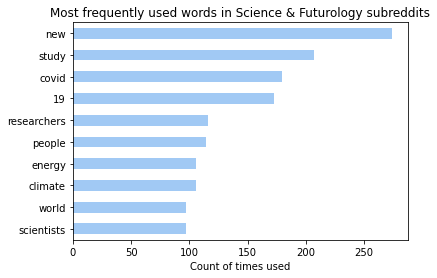

In [1122]:
# Convert training data to dataframe
X = pd.DataFrame(X.todense(), columns = cvec.get_feature_names())

# Plot top occurring words
X.sum().sort_values(ascending = False).head(10)[::-1].plot(kind = 'barh')

plt.title('Most frequently used words in Science & Futurology subreddits')
plt.xlabel('Count of times used');

<br>